# Deep Learning with Torch - Tutorial 4

## Transfer learning with convolutional networks


### We want to learn types of flowers, but we have a small dataset

  17
  80
   3
 128
 128
[torch.LongStorage of size 5]



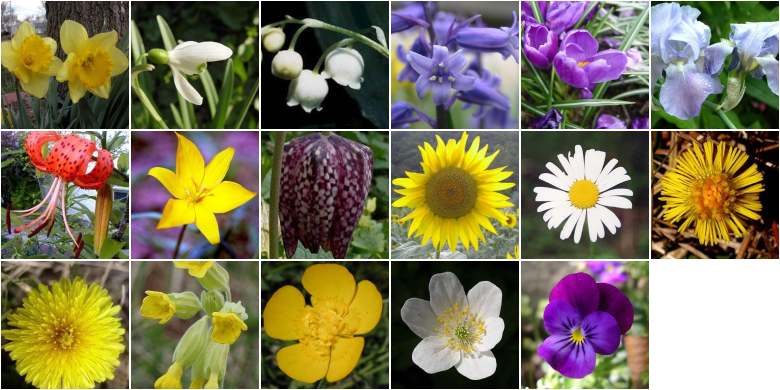

In [1]:
dataset = torch.load('flowers.t7')
classes = torch.range(1,17):totable() --17 classes
labels = torch.range(1,17):view(17,1):expand(17,80)
print(dataset:size()) --each class has 80 images of 3x128x128
itorch.image(dataset:select(2,1))

In [2]:
function shuffle(data,ydata) --shuffle data function
    local RandOrder = torch.randperm(data:size(1)):long()
    return data:index(1,RandOrder), ydata:index(1,RandOrder)
end



shuffledData, shuffledLabels = shuffle(dataset:view(-1,3,128,128), labels:contiguous():view(-1))

trainSize = 0.9 * shuffledData:size(1)
trainData, testData = unpack(shuffledData:split(trainSize, 1))
trainLabels, testLabels = unpack(shuffledLabels:split(trainSize, 1))

print(trainData:size())

 1224
    3
  128
  128
[torch.LongStorage of size 4]



## Data preprocess

In [3]:

trainData = trainData:float() -- convert the data from a ByteTensor to a float Tensor.
trainLabels = trainLabels:float()

mean, std = trainData:mean(), trainData:std()
print(mean, std)
trainData:add(-mean):div(std)
    
testData = testData:float()
testLabels = testLabels:float()
testData:add(-mean):div(std)

99.720683494684	69.403792697747	


## Using preTrained network
Since we don't have much training data, we will use a network pre trained on ImageNet (GoogLeNet v2)
It is freely available at:

https://github.com/eladhoffer/GoogLeNet.torch


In [19]:
require 'nn'
require 'cunn'
require 'cudnn'

googLeNet = torch.load('GoogLeNet_v2.t7')
--print(tostring(googLeNet))

## Chopping the network
Since we are interested mostly in low-level features, we will use the first 20 layers "only".

We will also make sure those layers will not be trained.

In [20]:
model = nn.Sequential()

for i=1,10 do
    local layer = googLeNet:get(i):clone()
    layer.parameters = function() return {} end --disable parameters
    layer.accGradParamters = nil --remove accGradParamters
    model:add(layer)
end

In [6]:
model:cuda()
local y = model:forward(torch.rand(1,3,128,128):cuda())
print(y:size())

   1
 320
  16
  16
[torch.LongStorage of size 4]



In [7]:
model:add(cudnn.SpatialConvolution(320, 16, 3,3))
model:add(cudnn.ReLU())
model:add(cudnn.SpatialMaxPooling(4,4))
model:add(nn.View(16*3*3):setNumInputDims(3))
model:add(nn.Dropout(0.5))
model:add(nn.Linear(16*3*3, #classes))
model:add(nn.LogSoftMax())

model:cuda()
criterion = nn.ClassNLLCriterion():cuda()
w, dE_dw = model:getParameters()
print('#Parameters = ', #w)

#Parameters = 	 48561
[torch.LongStorage of size 1]



## Training the network
We can now train the network efficiently. We'll do 25 epochs over all training data, shuffling the samples every epoch.

In [8]:
require 'optim'

batchSize = 16
optimState = {}


function forwardNet(data,labels, train)
    --another helpful function of optim is ConfusionMatrix
    local confusion = optim.ConfusionMatrix(classes)
    local lossAcc = 0
    local numBatches = 0
    if train then
        --set network into training mode
        model:training()
    else
        model:evaluate()
    end
    for i = 1, data:size(1) - batchSize, batchSize do
        numBatches = numBatches + 1
        local x = data:narrow(1, i, batchSize):cuda()
        local yt = labels:narrow(1, i, batchSize):cuda()
        local y = model:forward(x)
        local err = criterion:forward(y, yt)
        lossAcc = lossAcc + err
        confusion:batchAdd(y,yt)
        
        if train then
            function feval()
                model:zeroGradParameters() --zero grads
                local dE_dy = criterion:backward(y,yt)
                model:backward(x, dE_dy) -- backpropagation
            
                return err, dE_dw
            end
        
            optim.adam(feval, w, optimState)
        end
    end
    
    confusion:updateValids()
    local avgLoss = lossAcc / numBatches
    local avgError = 1 - confusion.totalValid
    
    return avgLoss, avgError, tostring(confusion)
end

function plotError(trainError, testError, title)
    local range = torch.range(1, trainError:size(1))
    local plot = itorch.Plot()
    plot:line(range, trainError * 100, 'red', 'Training error')
    plot:line(range, testError * 100, 'blue', 'Test error'):draw()
    plot:title(title):redraw()
    plot:xaxis('epoch'):yaxis('% error'):redraw()
    plot:legend(true)
    plot:redraw()
end

---------------------------------------------------------------------

epochs = 20
trainLoss = torch.Tensor(epochs)
testLoss = torch.Tensor(epochs)
trainError = torch.Tensor(epochs)
testError = torch.Tensor(epochs)



for e = 1, epochs do
    trainData, trainLabels = shuffle(trainData, trainLabels) --shuffle training data
    trainLoss[e], trainError[e] = forwardNet(trainData, trainLabels, true)
    testLoss[e], testError[e], confusion = forwardNet(testData, testLabels, false)
    
    if e % 2 == 0 then
        print('Epoch ' .. e .. ':')
        print('Training error: ' .. trainError[e], 'Training Loss: ' .. trainLoss[e])
        print('Test error: ' .. testError[e], 'Test Loss: ' .. testLoss[e])
    end
end

plotError(trainError, testError, 'Classification Error')

Epoch 2:	
Training error: 0.47861842105263	Training Loss: 1.5293821582669	
Test error: 0.3203125	Test Loss: 1.1201151683927	


Epoch 4:	
Training error: 0.25082236842105	Training Loss: 0.79492639691422	
Test error: 0.171875	Test Loss: 0.65551923215389	


Epoch 6:	
Training error: 0.16365131578947	Training Loss: 0.544490259925	
Test error: 0.1484375	Test Loss: 0.51448909938335	


Epoch 8:	
Training error: 0.13404605263158	Training Loss: 0.43640591204166	
Test error: 0.15625	Test Loss: 0.50725291483104	


Epoch 10:	
Training error: 0.10197368421053	Training Loss: 0.33614908099959	
Test error: 0.1328125	Test Loss: 0.42378934845328	


Epoch 12:	
Training error: 0.083059210526316	Training Loss: 0.26097500912453	
Test error: 0.140625	Test Loss: 0.40150428004563	


Epoch 14:	
Training error: 0.042763157894737	Training Loss: 0.18696522918579	
Test error: 0.09375	Test Loss: 0.36976581159979	


Epoch 16:	
Training error: 0.047697368421053	Training Loss: 0.16712547770064	
Test error: 0.1171875	Test Loss: 0.37467534467578	


Epoch 18:	
Training error: 0.044407894736842	Training Loss: 0.14858536932029	
Test error: 0.1015625	Test Loss: 0.3659555753693	


Epoch 20:	
Training error: 0.030427631578947	Training Loss: 0.12841479034212	
Test error: 0.1015625	Test Loss: 0.34229873586446	


# Deep Dreaming
A fun to visualize learned features is by using a trained network to optimize image space to maximize values within the net.

We will use the Taub building image

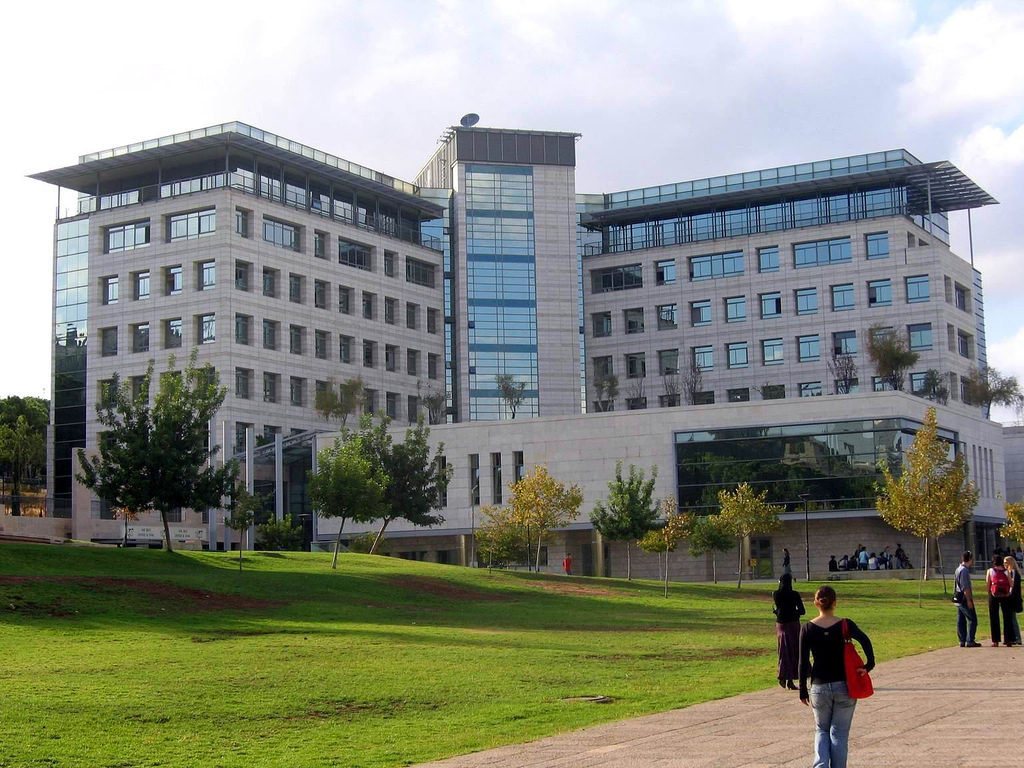

In [14]:
require 'image'
img = image.load('./taub.jpg'):float()
itorch.image(img)

In [15]:




local cuda = true
torch.setdefaulttensortype('torch.FloatTensor')

net = googLeNet:cuda()



local Normalization = {mean = 118.380948/255, std = 61.896913/255}

function reduceNet(full_net,end_layer)
    local net = nn.Sequential()
    for l=1,end_layer do
        net:add(full_net:get(l))
    end
    return net
end

function make_step(net, img, clip,step_size, jitter)
    local step_size = step_size or 0.05
    local jitter = jitter or 32
    local clip = clip
    if clip == nil then clip = true end

    local ox = 0--2*jitter - math.random(jitter)
    local oy = 0--2*jitter - math.random(jitter)
    img = image.translate(img,ox,oy) -- apply jitter shift
    local dst, g
    if cuda then
        local cuda_img = img:cuda():view(1,img:size(1),img:size(2),img:size(3))
        dst = net:forward(cuda_img)
        g = net:updateGradInput(cuda_img,dst):float():squeeze()
    else
        dst = net:forward(img)
        g = net:updateGradInput(img,dst)
    end
    -- apply normalized ascent step to the input image
    img:add(g:mul(step_size/torch.abs(g):mean()))


    img = image.translate(img,-ox,-oy) -- apply jitter shift
    if clip then
        bias = Normalization.mean/Normalization.std
        img:clamp(-bias,1/Normalization.std-bias)
    end
    return img
end

function deepdream(net, base_img, end_layer,iter_n, octave_n, octave_scale, clip, visualize)

    local iter_n = iter_n or 10
    local octave_n = octave_n or 4
    local octave_scale = octave_scale or 1.4
    local end_layer = end_layer or 30
    local net = reduceNet(net, end_layer)
    local clip = clip
    if clip == nil then clip = true end
    -- prepare base images for all octaves
    local octaves = {}
    octaves[octave_n] = torch.add(base_img, -Normalization.mean):div(Normalization.std)
    local _,h,w = unpack(base_img:size():totable())

    for i=octave_n-1,1,-1 do
        octaves[i] = image.scale(octaves[i+1], math.ceil((1/octave_scale)*w), math.ceil((1/octave_scale)*h),'simple')
    end


    local detail
    local src

    for octave, octave_base in pairs(octaves) do
        src = octave_base
        local _,h1,w1 = unpack(src:size():totable())
        if octave > 1 then
            -- upscale details from the previous octave
            detail = image.scale(detail, w1, h1,'simple')
            src:add(detail)
        end
        for i=1,iter_n do
            src = make_step(net, src, clip)
            if visualize then
                -- visualization
                vis = torch.mul(src, Normalization.std):add(Normalization.mean)

                if not clip then -- adjust image contrast if clipping is disabled
                    vis = vis:mul(1/vis:max())
                end

                image.display(vis)
            end
        end
        -- extract details produced on the current octave
        detail = src-octave_base
    end
    -- returning the resulting image
    src:mul(Normalization.std):add(Normalization.mean)
    return src

end



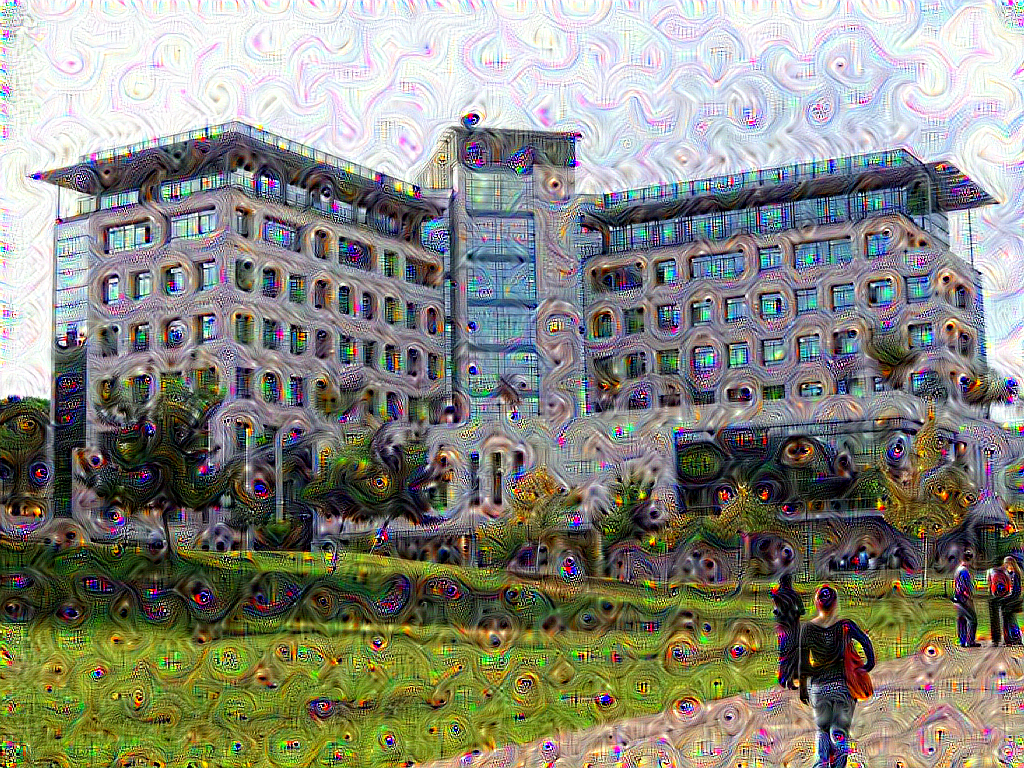

In [16]:
x = deepdream(net,img, 10)
itorch.image(x)


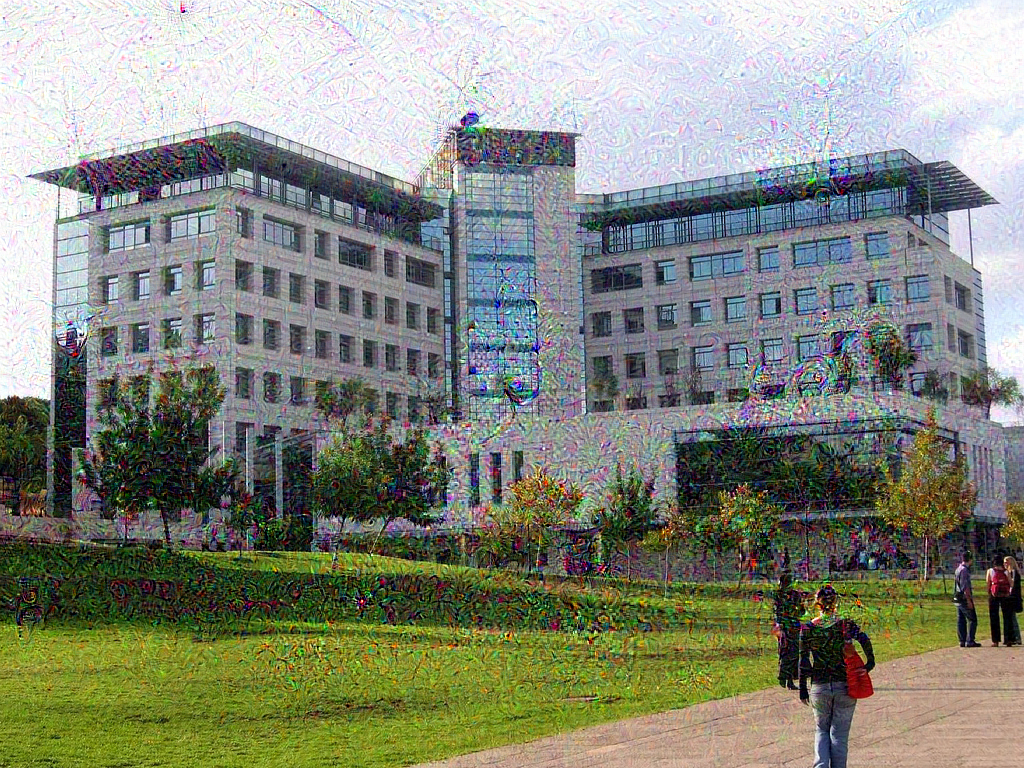

In [17]:
x = deepdream(net,img, 30)
itorch.image(x)

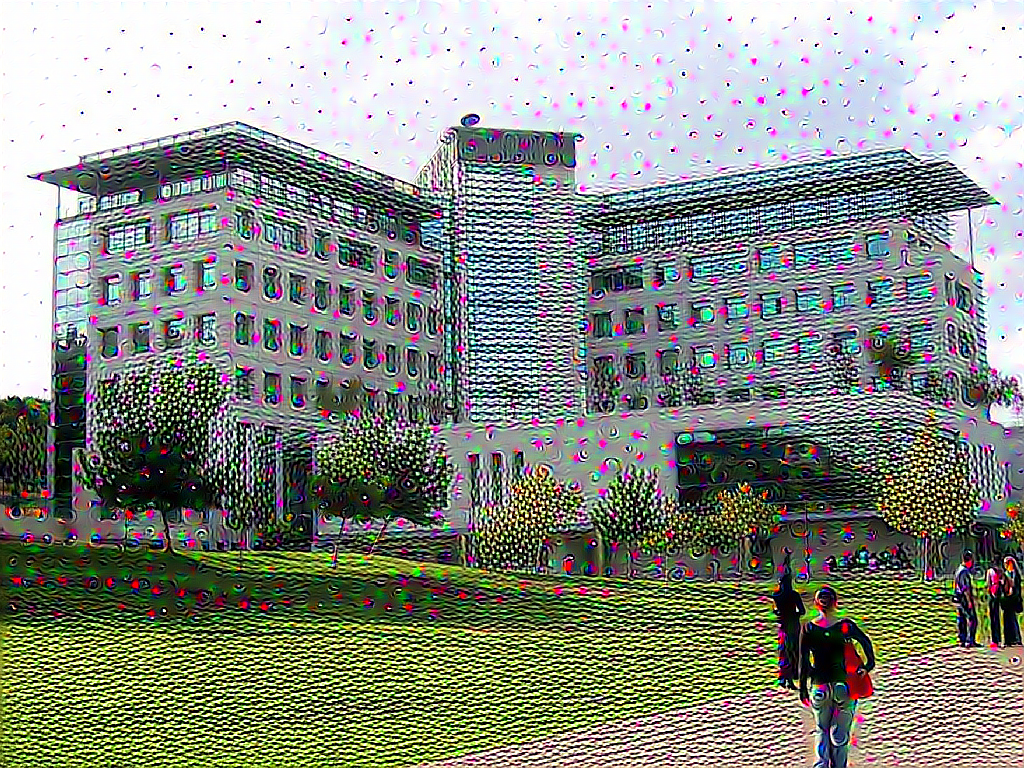

In [18]:
x = deepdream(net,img, 5)
itorch.image(x)